### Question: Can the current status of climate modes & antecedant soil moisture be used to estimate the probability of large inflows into the dam in the next 3-, or 6-months?

Storage capacity of the dam = 2,064,680 ML

Threshold inflows used for analyses:    
~20% of capacity = 400,000 ML  
~30% of capacity = 600,000 ML  

In [1]:
%who

Interactive namespace is empty.


In [228]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import os

def abline(slope, intercept, axes):
    """Plot a line from slope and intercept"""
    axes_xlim = axes.get_xlim()
    axes_ylim = axes.get_ylim()
    x_vals = np.append(np.append(np.array(axes_xlim[0]-500), np.array(axes.get_xlim())), np.array(axes_xlim[1]+500))
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, linestyle='-', color="lightgray", linewidth=1)
    axes.set(xlim = axes_xlim, ylim = axes_ylim)

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Process Data

In [289]:
# PROCESS DATA

# Inflow Data from Stuart
data_dir = '/g/data/w97/ad9701/warragamba_project/'
clim_data_file = 'Climate_Data_Monthly.csv'

df_clim = pd.read_csv(data_dir + clim_data_file)
# last row is blank. get rid of it
df_clim = df_clim[0:-1]

time_array = pd.to_datetime(df_clim['Month'].values, format='%d/%m/%Y').to_numpy().astype('datetime64[M]')
df_clim['time'] = time_array
df_clim = df_clim.set_index('time')
# df_clim.head()

# save inflow, dmi, and soi from the csv file
ds = df_clim['Inflow'].to_xarray().to_dataset()
ds['soi'] = df_clim['SOI'].to_xarray()
ds['dmi'] = df_clim['IOD-Standard'].to_xarray()

# get nino34 anomalies from file, the data appears to have been shifted by one time step in the csv file
ds_nino34 = xr.open_dataset(data_dir + 'nino34.long.anom.data.nc')
time_array_mon = ds_nino34['time'].values.astype('datetime64[M]')
ds_nino34 = ds_nino34.assign_coords({'time': time_array_mon})
ds['nino34_anom'] = ds_nino34['nino34_anom'].sel(time = slice('1970-01', None))

# get the SAM index from file
ds_sami = xr.open_dataset(data_dir + 'newsam.1957.2007.nc')
time_array_mon = ds_sami['time'].values.astype('datetime64[M]')
ds_sami = ds_sami.assign_coords({'time': time_array_mon})
ds['sami'] = ds_sami['sami'].sel(time = slice('1970-01', None))

# calculate & save the next 3-month cumulative inflows
ds['Inflow_3M'] = ds['Inflow'].rolling(time=3, center=False).sum().shift(time=-2)
# also 6-month
ds['Inflow_6M'] = ds['Inflow'].rolling(time=6, center=False).sum().shift(time=-5)

# year 2022 data for all the variables are not available, use data for 1970-2021
ds = ds.sel(time = slice('1970', '2021'))

## Statistics of cumulative inflows

- In the case of 3-month total inflows, 400,000 ML is between 85th and 90th percentiles, 600,000 ML between 90th and 95th. 
- For 6-month total inflows, 400,000 ML is less than the 75th perc & 600,000 ML slightly higher than the 80th perc.  
 

In [5]:
accum_name = ['3-month', '6-month']
var_name = ['Inflow_3M', 'Inflow_6M']

list_stats = []
quants = [0.75, 0.8, 0.85, 0.9, 0.95, 0.97, 0.99]
for accum, var in zip(accum_name, var_name):
    print(accum + ' Inflows: statistics')
    df_stats = pd.DataFrame({'Mean ': int(ds[var].mean().values),
                   'Median': int(ds[var].median().values),
                   'SD': int(ds[var].std().values),
                    '75th perc': int(ds[var].quantile(0.75).values),
                   '80th perc': int(ds[var].quantile(0.8).values),
                    '85th perc': int(ds[var].quantile(0.85).values),
                   '90th perc': int(ds[var].quantile(0.9).values),
                   '95th perc': int(ds[var].quantile(0.95).values),
                   '97th perc': int(ds[var].quantile(0.97).values),
                   '99th perc': int(ds[var].quantile(0.99).values)}, index=[0])
    temp_list = [df_stats['Median'].values[0]]
    temp_list.extend([df_stats[x].values[0] for x in ['75th perc', '80th perc', '85th perc', '90th perc', '95th perc', '97th perc', '99th perc']])
    list_stats.append(temp_list)
    print(df_stats.to_string(index=False))
    print('------------------------------------------------------------------------------------------------------')
    

3-month Inflows: statistics
 Mean   Median     SD  75th perc  80th perc  85th perc  90th perc  95th perc  97th perc  99th perc
193945   88087 276476     207416     274476     351274     495032     858792     998457    1271532
------------------------------------------------------------------------------------------------------
6-month Inflows: statistics
 Mean   Median     SD  75th perc  80th perc  85th perc  90th perc  95th perc  97th perc  99th perc
395241  213647 464435     508008     590368     754761    1055545    1348604    1593195    2369544
------------------------------------------------------------------------------------------------------


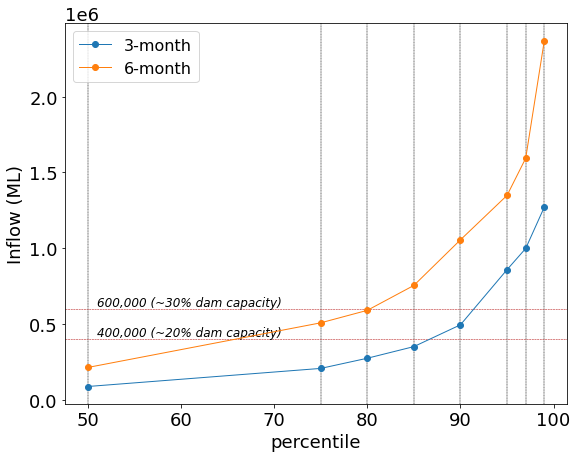

In [12]:
fig_dir = 'figures/warragamba/'

col_sel = sns.color_palette()[0:2]

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(9,7)) #width, height

perc_list = [50, 75, 80, 85, 90, 95, 97, 99]
thresh_list = [400000, 600000]

for data, col, label in zip(list_stats, col_sel, accum_name):    
    ax.plot(perc_list, data, marker='o', color=col, linewidth=1, zorder=10, label = label)
    
    for x in perc_list:
        plt.axvline(x, color = 'black', linestyle = 'dashed', linewidth = 0.3)
    
    for y in thresh_list:
        plt.axhline(y, color = 'indianred', linestyle = 'dashed', linewidth = 0.5)

plt.xlabel('')
ax.set_ylabel('Inflow (ML)')
ax.set_xlabel('percentile')
#ax.set_ylim((-120, 400))

plt.text(51, 420000, '400,000 (~20% dam capacity)', fontsize=12, fontstyle='italic')
plt.text(51, 620000, '600,000 (~30% dam capacity)', fontsize=12, fontstyle='italic')

ax.legend(loc=0)

# fig.savefig(fig_dir + 'inflow_percentiles_thresholds.png', bbox_inches='tight', dpi = 600)
# fig.savefig(fig_dir + 'inflow_percentiles_thresholds.pdf', bbox_inches='tight', format = 'pdf')

## How does the state of climate drivers affect cumulative inflows?

##### Climate driver classifications: 
ENSO positive: SOI >= +8   
ENSO neutral: SOI between -8 & +8  
ENSO negative: SOI <= -8  

IOD positive: IOD >= +0.4  
IOD neutral: IOD between -0.4 and +0.4  
IOD negative: IOD <= -0.4  

Table. The number of data points (months) in each bin

SOI/DMI | DMI -ve | DMI neutral | DMI +ve
:-|:-:|-:|-:
**SOI +ve**|21| 122 | 5  
**SOI neutral**|30| 271 | 28  
**SOI -ve**|11| 92 | 44

**Summary of results**
- The boxplots below show variations in inflows with ENSO/IOD phases
- In general, there are larger inflows during positive phases of the ENSO and negative phases of the IOD. This consistent with known influences of climate modes on rainfall.
- For some combinations of climate mode states, the differences in inflows are not clearly apparent from the box plots (eg: influence of IOD phases on 6-month timescales during neutral & positive ENSO phases)

In [291]:
# calc. & store the number of data points in each SOI/DMI bin (DMI order: pos, neu, neg). Values are shown in the table above
soineg_nPoints = []
soineg_nPoints.append(sum((ds['soi'] <= -8) & (ds['dmi'] >= 0.4)).values)
soineg_nPoints.append(sum((ds['soi'] <= -8) & (ds['dmi'] > -0.4) & (ds['dmi'] < 0.4)).values)
soineg_nPoints.append(sum((ds['soi'] <= -8) & (ds['dmi'] <= -0.4)).values)

soineu_nPoints = []
soineu_nPoints.append(sum((ds['soi'] < 8) & (ds['soi'] > -8) & (ds['dmi'] >= 0.4)).values)
soineu_nPoints.append(sum((ds['soi'] < 8) & (ds['soi'] > -8) & (ds['dmi'] > -0.4) & (ds['dmi'] < 0.4)).values)
soineu_nPoints.append(sum((ds['soi'] < 8) & (ds['soi'] > -8) & (ds['dmi'] <= -0.4)).values)

soipos_nPoints = []
soipos_nPoints.append(sum((ds['soi'] >= 8) & (ds['dmi'] >= 0.4)).values)
soipos_nPoints.append(sum((ds['soi'] >= 8) & (ds['dmi'] > -0.4) & (ds['dmi'] < 0.4)).values)
soipos_nPoints.append(sum((ds['soi'] >= 8) & (ds['dmi'] <= -0.4)).values)

# initialise a data.frame to store data for boxplots

plot_df = ds['Inflow_3M'].to_dataframe()
# plot_df.reset_index('time')

plot_df['Inflow_6M'] = ds['Inflow_6M']

enso_state = np.repeat('neutral', len(plot_df))
enso_state[np.where(ds['soi'].values >= 8)] = 'pos'
enso_state[np.where(ds['soi'].values <= -8)] = 'neg'

iod_state = np.repeat('neutral', len(plot_df))
iod_state[np.where(ds['dmi'].values >= 0.4)] = 'pos'
iod_state[np.where(ds['dmi'].values <= -0.4)] = 'neg'

plot_df['ENSO_state'] = enso_state
plot_df['IOD_state'] = iod_state

/local/zv2/ad9701/tmp/ipykernel_1850724/3974868973.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
/local/zv2/ad9701/tmp/ipykernel_1850724/3974868973.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


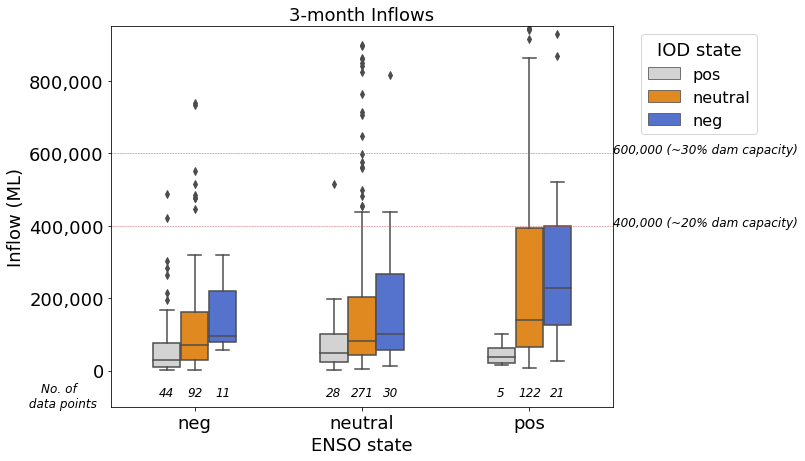

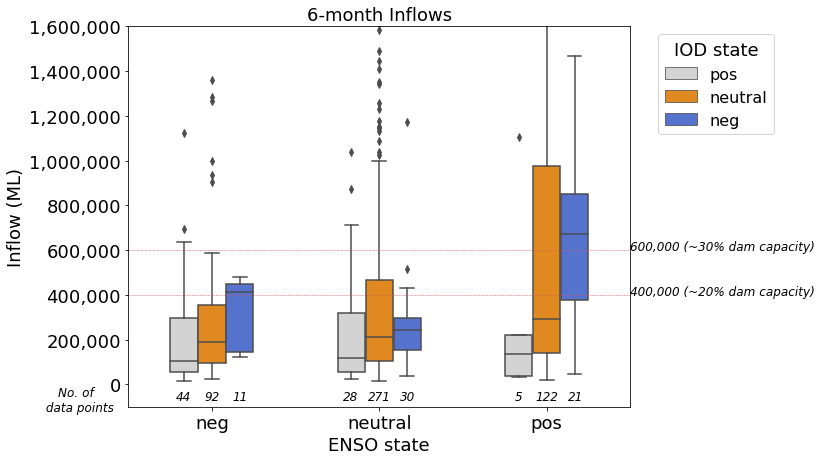

In [15]:
col_sel = ['lightgrey', 'darkorange', 'royalblue']

title_list = ['3-month Inflows', '6-month Inflows']
ylim_list = [(-100000, 950000), (-100000, 1600000)]

thresh_list = [400000, 600000]

for var, title, ylim in zip(['Inflow_3M','Inflow_6M'], title_list, ylim_list):
    fig, ax = plt.subplots(nrows=1,ncols=1,
                        figsize=(9,7)) #width, height

    # plot boxplot with seaborn
    bplot=sns.boxplot(y=var, x='ENSO_state', hue='IOD_state', 
                     data=plot_df, 
                     width=0.5,
                     palette=col_sel,
                     hue_order=['pos', 'neutral', 'neg'])

    ax.set_ylim(ylim)

    h_jitter = [-0.17, 0, 0.17]
    for xloc, data in zip([0, 1, 2], [soineg_nPoints, soineu_nPoints, soipos_nPoints]):
        for tt, h in zip(data, h_jitter):
            plt.text(xloc+h, -70000, str(tt), ha='center', fontstyle='italic', fontsize=12)
    plt.text(-0.8, -70000, 'No. of \n data points', ha='center', va='center', fontstyle='italic', fontsize=12)

    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='IOD state')
    plt.xlabel('ENSO state')
    plt.ylabel('Inflow (ML)')
    plt.title(title)
    
    for y in thresh_list:
        plt.axhline(y, color = 'indianred', linestyle = 'dashed', linewidth = 0.5)
    plt.text(2.5, 400000, '400,000 (~20% dam capacity)', fontsize=12, fontstyle='italic')
    plt.text(2.5, 600000, '600,000 (~30% dam capacity)', fontsize=12, fontstyle='italic')
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

    # fig.savefig(fig_dir + var + '_boxplots.png', bbox_inches='tight', dpi = 600)
    # fig.savefig(fig_dir + var + '_boxplots.pdf', bbox_inches='tight', format = 'pdf')

## How does antecedant soil mositure affect the inflows?

Soil moisture is from the AWRA dataset in units of 'fraction of fullness'. Catchment averages are calculated using the approximate shapefile

**Summary of results**
- The antecedant moisture condition has a strong influence on inflows. The influence is lowest in SON.

#### Look at variation of subsequent cumulative inflows with ancedant SM, by season
The sm values vary between (0.02, 0.82)  
Using the following sm classifications for the box plots. I selected these bin limits to have similar number of data points in the different bins.  
Table. The number of data points in soil moisture classifications used for analyses.  

SM | bin ranges | DJF | JJA | MAM | SON 
:-|:-:|-:|-:|-:|-:
**Dry**|(0, 0.25]| 57 | 32 | 33 | 40
**Intermediate**|(0.25, 0.5]| 85 | 93 | 90 | 95
**Wet**|(0.5, 0.82]| 14 | 31 | 33 | 21


In [16]:
ds_sm = xr.open_dataset('/g/data/w97/ad9701/warragamba_project/sm_pct_regavg.nc')

# get the soil moisture condition at the beginning of the month
da_sm = ds_sm['sm_pct_regavg'].sel(time = ds.time.values)

# add soil mositure to the plot dataframe
plot_df['SM'] = da_sm.values

sm_state = np.repeat('intermediate', len(plot_df))
sm_state[np.where(da_sm.values > 0.5)] = 'wet'
sm_state[np.where(da_sm.values <= 0.25)] = 'dry'

plot_df['SM_state'] = sm_state
plot_df['season'] = da_sm['time.season'].values

/local/zv2/ad9701/tmp/ipykernel_1850724/762293691.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
/local/zv2/ad9701/tmp/ipykernel_1850724/762293691.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


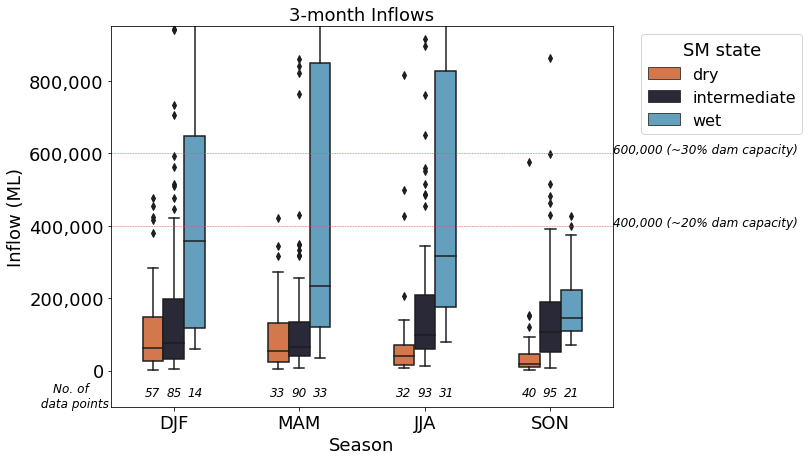

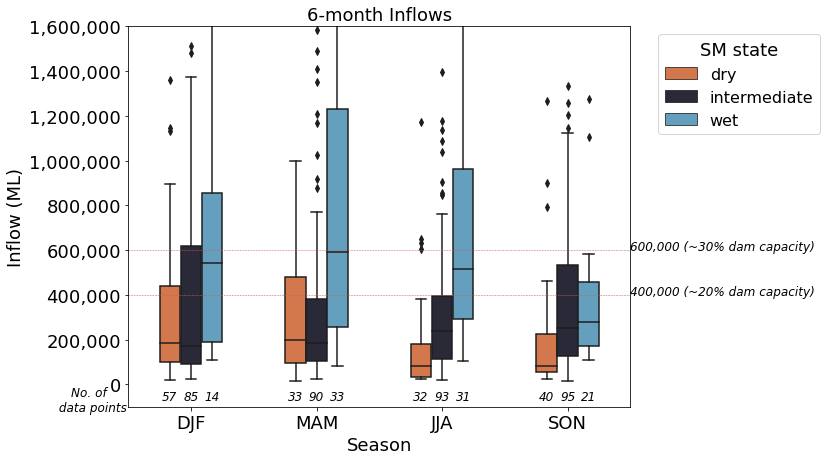

In [18]:
pal = sns.color_palette("icefire_r",6)
col_sel = [pal[0], pal[3], pal[5]]

# calc. & store the number of data points in each SM bin (by season)
sm_nPoints_dry = (da_sm <= 0.25).groupby('time.season').sum()
sm_nPoints_intermediate = ((da_sm <= 0.5) & (da_sm > 0.25)).groupby('time.season').sum()
sm_nPoints_wet = (da_sm > 0.5).groupby('time.season').sum()

seas_order = ['DJF', 'MAM', 'JJA', 'SON']

title_list = ['3-month Inflows', '6-month Inflows']
ylim_list = [(-100000, 950000), (-100000, 1600000)]

thresh_list = [400000, 600000]

for var, title, ylim in zip(['Inflow_3M','Inflow_6M'], title_list, ylim_list):
    fig, ax = plt.subplots(nrows=1,ncols=1,
                        figsize=(9,7)) #width, height

    # plot boxplot with seaborn
    bplot=sns.boxplot(y=var, x='season', hue='SM_state', 
                     data=plot_df, 
                     width=0.5,
                     palette=col_sel,
                     order=seas_order,
                     hue_order=['dry', 'intermediate', 'wet'])

    ax.set_ylim(ylim)

    h_jitter = [-0.17, 0, 0.17]
    nPoints_list = [[da.sel(season = seas).values for da in [sm_nPoints_dry, sm_nPoints_intermediate, sm_nPoints_wet]] for seas in seas_order]
    for xloc, data in zip([0, 1, 2, 3], nPoints_list):
        for tt, h in zip(data, h_jitter):
            plt.text(xloc+h, -70000, str(tt), ha='center', fontstyle='italic', fontsize=12)
    plt.text(-0.8, -70000, 'No. of \n data points', ha='center', va='center', fontstyle='italic', fontsize=12)

    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='SM state')
    plt.xlabel('Season')
    plt.ylabel('Inflow (ML)')
    plt.title(title)
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    for y in thresh_list:
        plt.axhline(y, color = 'indianred', linestyle = 'dashed', linewidth = 0.5)
    plt.text(3.5, 400000, '400,000 (~20% dam capacity)', fontsize=12, fontstyle='italic')
    plt.text(3.5, 600000, '600,000 (~30% dam capacity)', fontsize=12, fontstyle='italic')

    # fig.savefig(fig_dir + var + '_boxplots_sm_by_season.png', bbox_inches='tight', dpi = 600)
    # fig.savefig(fig_dir + var + '_boxplots_sm_by_season.pdf', bbox_inches='tight', format = 'pdf')

## Logistic regression for probability of exceedance: Individual predictors

Probability (3M/6M-Cumulative Inflows > Threshold) ~ (season, SOI<sub>previous-month</sub>).  
Probability (3M/6M-Cumulative Inflows > Threshold) ~ (season, DMI<sub>previous-month</sub>).  
Probability (3M/6M-Cumulative Inflows > Threshold) ~ (season, SM<sub>current-day</sub>)   
  
The p-value of the predictor is shown on the plots below. Significant pvalues below 0.05 are indicated in bold text.
  
**Summary of results**

- SM is a significant predictor in seasons except SON  
- ENSO is a significant predictors in seasons JJA, SON, DJF. Most consistently in season JJA  
- IOD appears to be a less significant predictor. For 3-month accumulations, IOD is a significant predictor in JJA. For 6-month accumulations, it is a significant predictor in MAM & SON.

  
The plotting function used below generated the uncertainty estimates which are shown as the shaded areas. Probability estimates during extremevalues of predictors have large uncertantity. These uncertainity estimates are based on model fits using 1000 samples of the same length generated from the original data, with replacement. This uncertainty probably comes from the small sample size which has a few extreme predictor values(here we have 156 total data points during each season for the model fit).  
  
reference for bootstrapping if required later: https://notebook.community/sarajcev/logreg-linreg/logreg-compare

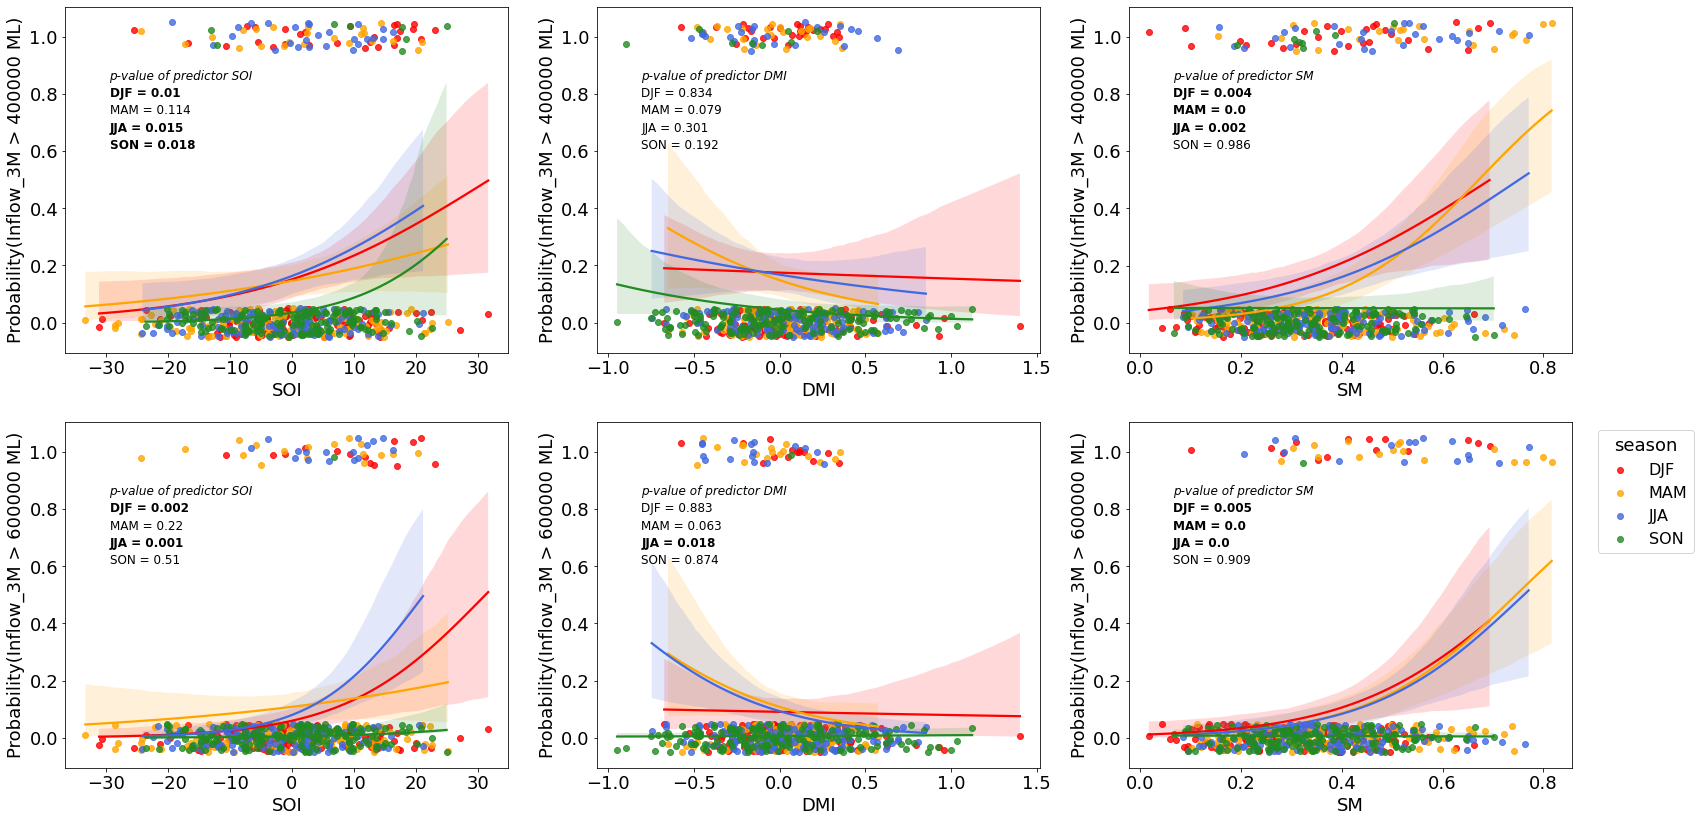

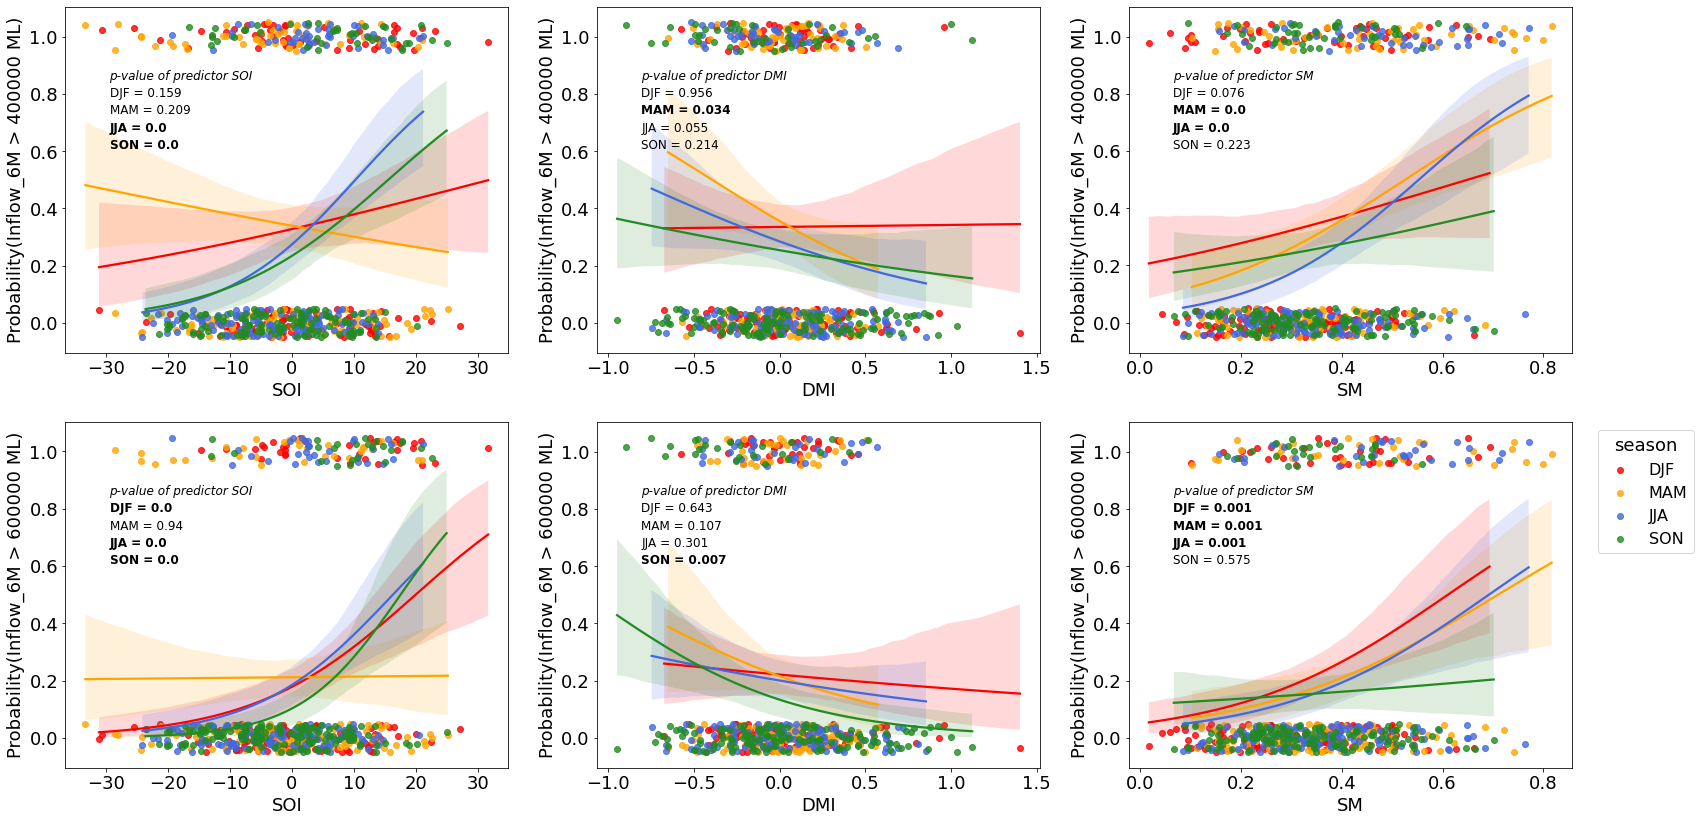

In [150]:
# Testing logistic fits for responses using individual predictors

from statsmodels.formula.api import glm
import statsmodels.api as sm

thresh_list = [400000, 600000]

seas_list = ['DJF', 'MAM', 'JJA', 'SON']
col_list = ['red', 'orange', 'royalblue', 'forestgreen']

for var in ['Inflow_3M','Inflow_6M']:
    fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(9*3,7*2)) #width, height
    ax = ax.flatten()
    count = 0
    for thresh in thresh_list:
        # the response variable; 1 if it exceeded the threshold, 0 otherwise
        y = np.where(ds[var].values >= thresh, 1, 0)
        
        # the predictors: season, climate modes & soil moisture
        d = {"response": y[1:len(y)], 
             "season": ds['time.season'].values[1:len(y)],
             "SOI":ds['soi'].values[0:(len(y)-1)],
             "DMI":ds['dmi'].values[0:(len(y)-1)],
             "SM":da_sm.values[1:len(y)]}
        df = pd.DataFrame(d)

        # How does the response relate to the predictors, individually?
        for p in ['SOI', 'DMI', 'SM']:
            ax[count].text(0.1, 0.8, 'p-value of predictor ' + p, ha='left', va='center', transform=ax[count].transAxes, fontsize=12, fontstyle='italic')
            seas_count=1
            for seas, col in zip(seas_list, col_list):
                sns.regplot(x=p, y="response", data=df[df['season']==seas], logistic=True, y_jitter=.05, color=col, ax=ax[count], label = seas)
                ax[count].set_ylabel('Probability(' + var + ' > ' + str(thresh) + ' ML)')
                # fit the model and get the pvalue of the predictor
                formula = 'response ~ ' + p
                model = glm(formula, df[df['season']==seas], family=sm.families.Binomial())
                res = model.fit()
                pval = np.round(res.pvalues.values[1], 3)
                if pval < 0.05:
                    fontweight = 'bold'
                else:
                    fontweight = 'normal'
                ax[count].text(0.1, 0.8-(0.05*seas_count), seas + ' = ' + str(pval), ha='left', va='center', 
                               transform=ax[count].transAxes, fontsize=12, fontweight = fontweight)
                seas_count=seas_count+1
            count = count+1
    
    ax[count-1].legend(bbox_to_anchor=(1.04,1), loc="upper left", title='season')
    fig.savefig(fig_dir + var + '_logiRegr_curves_individual_pred_monthBef.png', bbox_inches='tight', dpi = 600)
    fig.savefig(fig_dir + var + '_logiRegr_curves_individual_pred_monthBef.pdf', bbox_inches='tight', format = 'pdf')

## Logistic regression for probability of exceedance: Model using all predictors

Probability (3M/6M-Cumulative Inflows > Threshold) ~ (season, SM<sub>current-day</sub>, SOI<sub>previous-month</sub>, DMI<sub>previous-month</sub>). 

**Four GLM models above used to model the below cases:**   
probability(3-month inflows > 400,000 ML)  
probability(3-month inflows > 600,000 ML)  
probability(6-month inflows > 400,000 ML)  
probability(6-month inflows > 600,000 ML)  

In [50]:
from statsmodels.formula.api import glm
import statsmodels.formula.api as smf
import statsmodels.api as sm

formula = 'response ~ SOI + DMI + SM'
seas_list = ['DJF', 'MAM', 'JJA', 'SON']
thresh_list = [400000, 600000]

# The variables that need to be saved from the GLM model fits
# params.values # the model 

nParams = 4 # the model would have 4 parameters: Intercept + 3 predictors
nPred = nParams - 1

glm_models = {}
fitted_contrib_values = {}
for var in ['Inflow_3M','Inflow_6M']:
    list_pred = []
    list_params = []
    list_pvalues = []
    list_bse = []
    list_season = []
    list_threshold = []
    
    list_seas_forFitted = []
    list_thresh_forFitted = []
    list_fitted = []
    list_contrib_pred1 = []
    list_contrib_pred2 = []
    list_contrib_pred3 = []
    
    for thresh in thresh_list:
        y = np.where(ds[var].values >= thresh, 1, 0)
        # the predictors: season, climate modes & soil moisture
        d = {"response": y, "season": ds['time.season'].values, "SOI":ds['soi'].values, "DMI":ds['dmi'].values, "SM":da_sm.values}
        df = pd.DataFrame(d)
        
        for seas in seas_list:
            model = glm(formula, df[df['season'] == seas], family=sm.families.Binomial())
            res = model.fit()
            
            # save results
            list_pred.extend(res.params.keys().values)
            list_params.extend(res.params.values)
            list_pvalues.extend(res.pvalues.values)
            list_bse.extend(res.bse.values)
            list_threshold.extend([thresh]*nParams)
            list_season.extend([seas]*nParams)
            
            # save fitted values & identifying factors (season, threshold)
            list_fitted.append(res.fittedvalues.values)
            list_seas_forFitted.extend([seas])
            list_thresh_forFitted.extend([thresh])
            
            # also save the probabilities contributed by individual predictors in the combined model
            predList = res.params.index.values[1::]
            temp_list = []
            for pred in res.params.index.values[1::]:
                # get terms corresponding to other predictors in the GLM model
                otherPred_terms = []
                for otherPred in predList[predList != pred]:
                    otherPred_terms.append((res.params[otherPred]*df[df['season'] == seas][otherPred]).values)
                logodds_exclPred = res.params['Intercept'] + otherPred_terms[0] + otherPred_terms[1]
                prob_exclPred = np.exp(logodds_exclPred)/(1+np.exp(logodds_exclPred))
                prob_contrib = res.fittedvalues.values - prob_exclPred
                temp_list.append(prob_contrib)
            
            list_contrib_pred1.append(temp_list[0])
            list_contrib_pred2.append(temp_list[1])
            list_contrib_pred3.append(temp_list[2])
            
    df_results = pd.DataFrame({'predictors': list_pred,
                               'params': list_params,
                               'pvalues': list_pvalues,
                               'std_err': list_bse,
                               'threshold': list_threshold,
                               'season': list_season})
    dict_fitted_contrib = {'fittedValues': list_fitted, 
                   predList[0] + '_contrib': list_contrib_pred1,
                   predList[1] + '_contrib': list_contrib_pred2,
                   predList[2] + '_contrib': list_contrib_pred3,
                   'seas_thresh_info': pd.DataFrame({'season': list_seas_forFitted, 'threshold': list_thresh_forFitted})}   
                
    glm_models.update({var: df_results})
    fitted_contrib_values.update({var: dict_fitted_contrib})

### Probability contributions from each term (predictor) in the combined model

**Summary of results**
- The antecedant soil moisture typically has the largest influence on probabilities in all seasons except SON.
- The climate modes (ENSO & IOD) have larger probability contributions during JJA and MAM. 
- Literature reports that the influence of ENSO on rainfall is assymetric with larger influences during positive phases of the mode. Such an assymetry is also visible in the probability contributions below.
- All predictors have low influences on inflows during SON

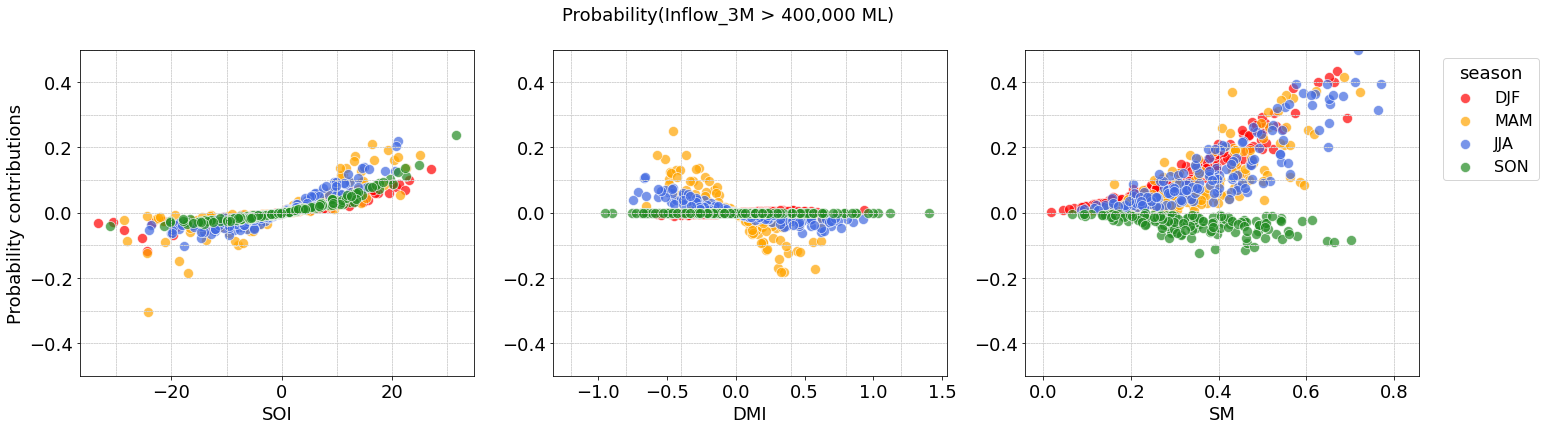

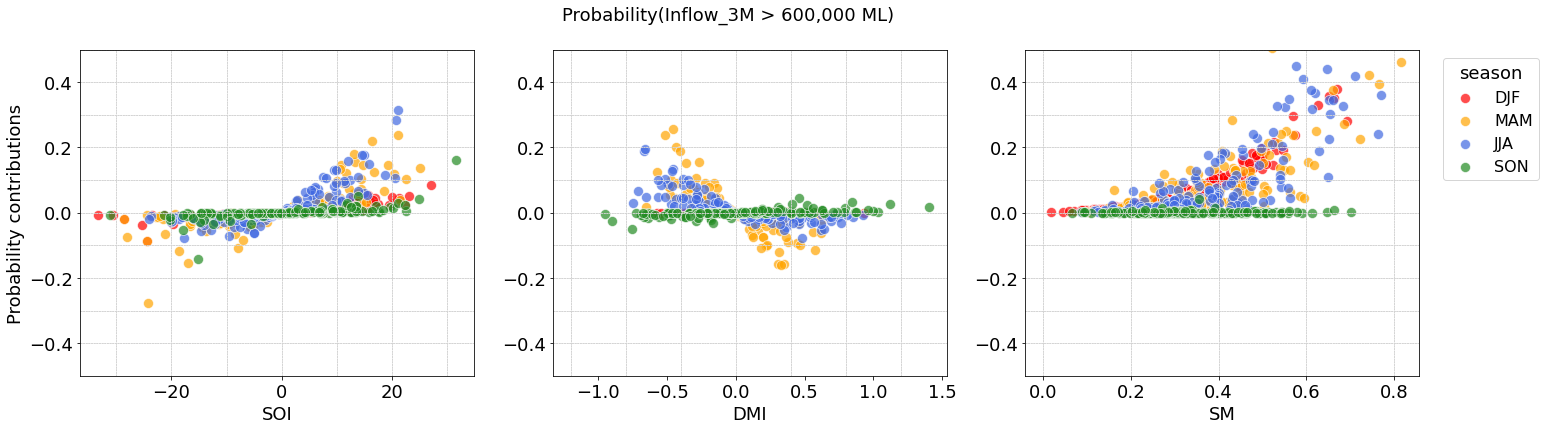

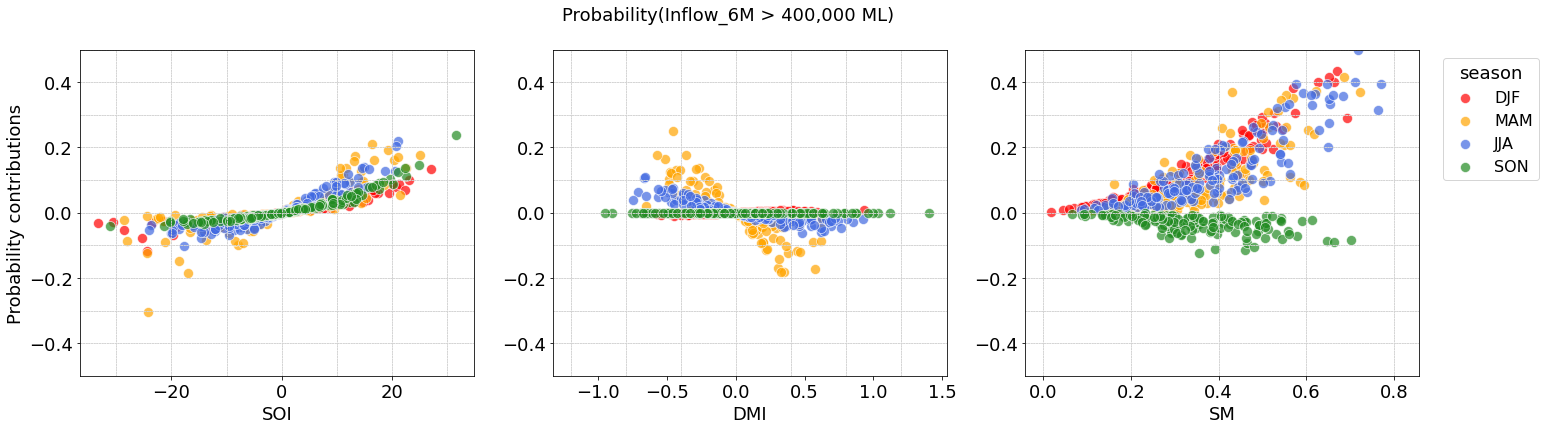

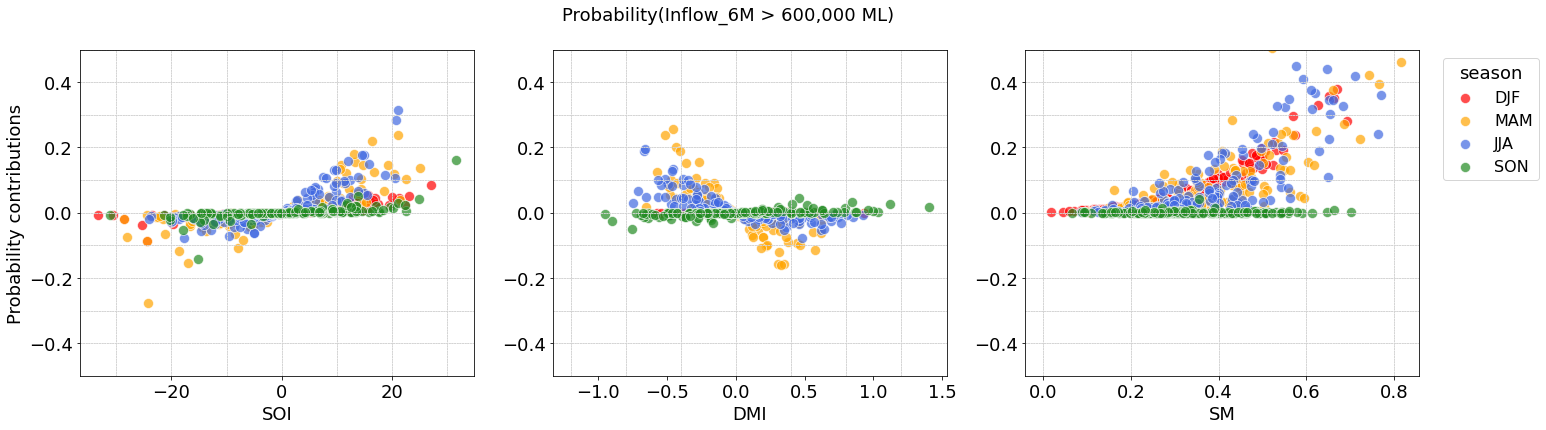

In [290]:
d = {"response": y, "season": ds['time.season'].values, "SOI":ds['soi'].values, "DMI":ds['dmi'].values, "SM":da_sm.values}
df = pd.DataFrame(d)

# values used to create reference lines
prob_ref = [-0.5, -0.3, -0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
soi_ref = [-30, -20, -10, 0, 10, 20, 30]
dmi_ref = [-1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2]
sm_ref = [0, 0.2, 0.4, 0.6, 0.8]
col_refline = 'lightgrey'
lwd_refline = 0.5
ylim = (-0.5, 0.5)

col_list = ['red', 'orange', 'royalblue', 'forestgreen']
seas_list = ['DJF', 'MAM', 'JJA', 'SON']

for inflowAccum in ['Inflow_3M', 'Inflow_6M']:
    seas_thresh_info = fitted_contrib_values[inflowAccum]['seas_thresh_info']

    for thresh_sel in [400000, 600000]:
        titleText = 'Probability(' + inflowAccum + ' > ' + str('{:,.0f}'.format(thresh_sel)) + ' ML)'

        fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(8*3, 6)) #width, height
        ax = ax.flatten()

        for col, seas in zip(col_list, seas_list):
            indSel = ((seas_thresh_info['season'] == seas) & (seas_thresh_info['threshold'] == thresh_sel)).values
            indSel = np.where(indSel == True)[0][0]

            df_seas_thresh = df[df['season'] == seas].copy(deep=True)
            for varname in ['SOI_contrib', 'DMI_contrib', 'SM_contrib']:
                df_seas_thresh[varname] = fitted_contrib_values['Inflow_3M'][varname][indSel]

            sns.scatterplot(df_seas_thresh, x='SOI', y='SOI_contrib', color=col, legend=False, label=seas, ax=ax[0], s=100, alpha=0.7) #
            sns.scatterplot(df_seas_thresh, x='DMI', y='DMI_contrib', color=col, legend=False, label=seas, ax=ax[1], s=100, alpha=0.7) #
            sns.scatterplot(df_seas_thresh, x='SM', y='SM_contrib', color=col, legend=False, label=seas, ax=ax[2], s=100, alpha=0.7) #

            ax[0].set_ylabel('Probability contributions')
            ax[1].set_ylabel('')
            ax[2].set_ylabel('')
            for yval in soi_ref:
                ax[0].axvline(yval, color = col_refline, linestyle = 'dashed', linewidth = lwd_refline)
            for yval in dmi_ref:
                ax[1].axvline(yval, color = col_refline, linestyle = 'dashed', linewidth = lwd_refline)
            for yval in sm_ref:
                ax[2].axvline(yval, color = col_refline, linestyle = 'dashed', linewidth = lwd_refline)

            for iax in range(3):
                for xval in prob_ref:
                    ax[iax].axhline(xval, color = col_refline, linestyle = 'dashed', linewidth = lwd_refline)
                ax[iax].set_ylim(ylim)
            ax[2].legend(bbox_to_anchor=(1.04,1), loc="upper left", title='season')

            fig.suptitle(titleText)
            
        # fig.savefig(fig_dir + inflowAccum + '_thresh_' + str(thresh_sel) + '_predictor_contributions.png', bbox_inches='tight', dpi = 600)
        # fig.savefig(fig_dir + inflowAccum + '_thresh_' + str(thresh_sel) + '_predictor_contributions.pdf', bbox_inches='tight', format = 'pdf')

## In-sample validation of the multi-predictor models

Calculate the proportion of times when the inflows exceeded thresholds and compare with the modelled probabilities to perform in-sample validation of the GLM models.
 
**Summary of results**
- In-sample validation results for the 4 GLM models are shown using model vs. observed scatter plots below. Square and round markers are used to show the two thresholds studied.
- The GLM models that are used to model exceedances over 600,000 ML perform well (the square markers in the plots)
- The GLM models used to model for exceedances abover 400,000 ML (round markers) show an overestimation of modelled probability comnpared to observed proportions (model estimates > observed proportions for data in the model probability bin)

Note: The observed proportions calculated here are subject to sampling errors due to the length of the dataset and there is no way to avoid this. The darker shade of blue is used to indicate observed proportions calculated from larger samples (> 50 data points), which is expected to be more accurate. The higher probability bins don't contain enough data points to calculate observed estimates (hence they are blank in the plots below).

In [275]:
def calc_obs_prop(model_array, obs_array, model_min, model_max):
    # get the index of values that fall in the model bin
    model_bin = np.where((model_array <= model_max) & (model_prob > model_min))[0]
    if len(model_bin) > 0:
        obs_prop = np.sum(obs_array[model_bin])/len(model_bin)
        model_median = np.median(model_array[model_bin])
    else:
        obs_prop = np.nan
        model_median = np.nan
    return obs_prop, model_median, len(model_bin)

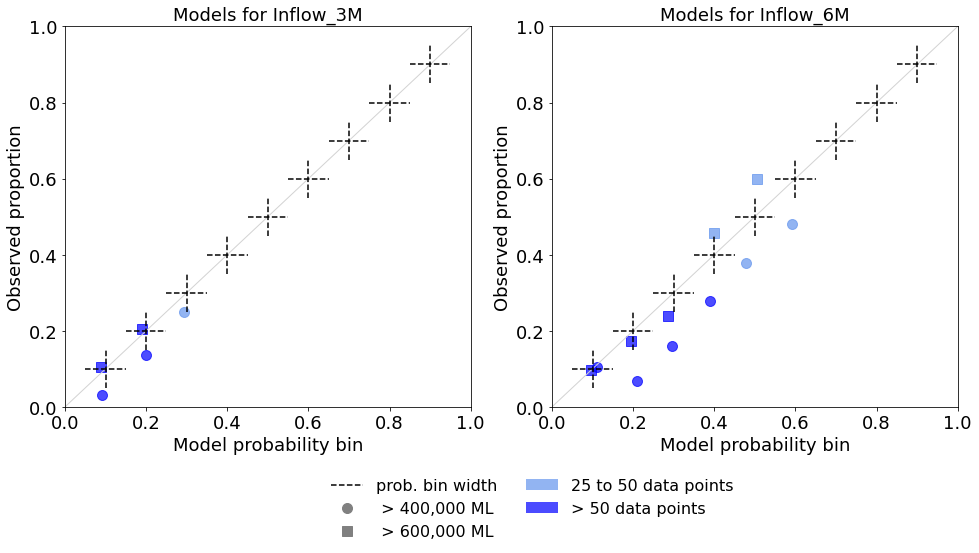

In [288]:
seas_list = ['DJF', 'MAM', 'JJA', 'SON']

bin_min = np.linspace(0.05, 0.85, 9)
bin_max = np.linspace(0.15, 0.95, 9)
bin_centre = np.linspace(0.1, 0.9, 9)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8*2, 7)) #width, height
ax = ax.flatten()

col1 = 'cornflowerblue'
col2 = 'blue'
axlim = (0, 1)

marker_list = ['o', 's']

count_accum=0
for inflowAccum in ['Inflow_3M', 'Inflow_6M']:
    seas_thresh_info = fitted_contrib_values[inflowAccum]['seas_thresh_info']
    
    count = 0
    for thresh_sel in [400000, 600000]:
        y = np.where(ds[inflowAccum].values >= thresh, 1, 0)
        # the predictors: season, climate modes & soil moisture
        d = {"response": y, "season": ds['time.season'].values, "SOI":ds['soi'].values, "DMI":ds['dmi'].values, "SM":da_sm.values}
        df = pd.DataFrame(d)
            
        # collate data from all seasons
        model_prob = []
        obs_exceed = []
        for seas in seas_list:
            # model data
            indMdl = ((seas_thresh_info['season'] == seas) & (seas_thresh_info['threshold'] == thresh_sel)).values
            indMdl = np.where(indMdl == True)[0][0]
            model_prob.extend(fitted_contrib_values[inflowAccum]['fittedValues'][indMdl])
            # observed exceedance
            obs_exceed.extend(df['response'][df['season'] == seas])
        model_prob = np.array(model_prob)
        obs_exceed = np.array(obs_exceed)

        # calculated observed proportion of months during which subsequent inflows exceeded the thresholds, for each model probability bin
        obs_prop_byBin = []
        model_median_byBin = []
        nMonths_byBin = []
        for minVal, maxVal in zip(bin_min, bin_max):
            obs_prop, model_median, nMonths = calc_obs_prop(model_prob, obs_exceed, minVal, maxVal)
            obs_prop_byBin.append(obs_prop)
            model_median_byBin.append(model_median)
            nMonths_byBin.append(nMonths)
        
        model_median_byBin = np.array(model_median_byBin)
        obs_prop_byBin = np.array(obs_prop_byBin)
        nMonths_byBin = np.array(nMonths_byBin)
        
        # Plot: Observed proportion (y-axis) vs. Model probability (x-axis)
        # estimates from 25 to 50 data points
        ind1 = np.where((nMonths_byBin < 50) & (nMonths_byBin >= 25))
        ax[count_accum].scatter(model_median_byBin[ind1], obs_prop_byBin[ind1], s = 100, alpha = 0.7, color = col1, marker = marker_list[count])

        # estimates from more than 50 data points
        ind2 = np.where(nMonths_byBin >= 50)
        ax[count_accum].scatter(model_median_byBin[ind2], obs_prop_byBin[ind2], s = 100, alpha = 0.7, color = col2, marker = marker_list[count])
        count = count+1
        # print(np.round(obs_prop_byBin,3))
    
    ax[count_accum].set_title('Models for ' + inflowAccum)
    count_accum = count_accum+1
    

# Bin markings
#------------------
for axis in ax:
    axis.set_xlim(axlim)
    axis.set_ylim(axlim)
    abline(1, 0, axis)
    for xx in bin_centre:
        axis.axvline(x=xx, ymin=xx-0.05, ymax=xx+0.05, linestyle='--', color = 'black')
        axis.axhline(y=xx, xmin=xx-0.05, xmax=xx+0.05, linestyle='--', color = 'black')
    axis.set_xlabel('Model probability bin')
    axis.set_ylabel('Observed proportion')
        
# Legend
#------------------
labels = [' > ' + str('{:,.0f}'.format(thresh)) + ' ML' for thresh in [400000, 600000]]
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='k', label='prob. bin width', linestyle='--'),
                   Line2D([0], [0], marker=marker_list[0], color='grey', label=labels[0], markerfacecolor='grey', markersize=10, linewidth=0),
                   Line2D([0], [0], marker=marker_list[1], color='grey', label=labels[1], markerfacecolor='grey', markersize=10, linewidth=0)]
legend_elements2 = [Patch(facecolor=col1, edgecolor=None, alpha=0.7, label='25 to 50 data points'),
                   Patch(facecolor=col2, edgecolor=None, alpha=0.7, label='> 50 data points')]

ax[0].legend(handles=legend_elements, bbox_to_anchor=(1.1,-0.15), frameon=False)
ax[1].legend(handles=legend_elements2, bbox_to_anchor=(-0.1,-0.15), frameon=False)

# fig.savefig(fig_dir + 'scatterPlot_inSample_validation.png', bbox_inches='tight', dpi = 600)
# fig.savefig(fig_dir + 'scatterPlot_inSample_validation.pdf', bbox_inches='tight', format = 'pdf')